# Multidimensional Scaling

In 12 hours I'll be finishing my last exam for my masters! This one is for [Data Mining and Exploration](https://www.inf.ed.ac.uk/teaching/courses/dme/). One topic we covered was *Multidimensional Scaling* (MDS), which turns out to require a lot of the neat things we learned in class. MDS methods take similarity between pairs of points, such as distance, and uses them to estimate where the points are in space while trying to preserve their pairwise similarity. This method is useful if you want to visualize points but all you have is a measure of something like distance.

One way of doing MDS is to assume the similarities are Euclidean distances. While other MDS techniques require iterative optimization, the Euclidean-distance-based approach has a closed-form solution based on PCA.

To summarize, MDS takes in $\Delta$, an $N \times N$ symmetric matrix of distances, and returns a $K \times N$ matrix of embedded data points, where $N$ is the number of examples in our dataset, and $K$ is a user-defined number of dimensions that the points should be in.

In order to demonstrate MDS, I first generate fake underlying data points and then compute distances from them. Then I'll compute a few other forms that will be useful for comparision: the *Gram matrix* and a centered data matrix using a *centering matrix*.
Then I'll apply MDS to the generated distance matrix. At the end, I apply MDS to a dataset of distances between North American cities resulting in the plot below. It might be squashed and upside-down, but it almost looks like a map of North America!

![](images/2018-05-20-north-america-per-state-province.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import euclidean_distances

In [2]:
# helper functions you can skip over :D
def hide_ticks(plot):
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)

SAVE = True
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")

## Data generation

Usually the point of using MDS is you don't have the underlying points. However, I'll generate some points so I can get a distance matrix from them as well as compare intermediate forms. In this case, the underlying data is in a much higher dimension.

I'll start with some Gaussian data that is rotated and shifted. I also define some constants:

 - $N$: the number of underlying data points.
 - $D$: the dimension of these points.
 - $K$: the dimension I want to the resulting data points to be in.
 
Heads up, in this post, I'm saying $X$ has shape $D \times N$.

In [3]:
N = 1000
D = 20
K = 2

# rotate and uncenter the data
X = (2 * np.random.rand(D, D)) @ np.random.randn(D, N) + np.arange(D)[:, None]

## Centering matrix

In order to implement MDS, I'll need to use the *centering matrix*. This is given by the $n \times n$ matrix

$$C_n = \mathbb{I}_n - \frac 1 n \mathbb{1}_n \times \mathbb{1}_n^{\top}$$

where $\mathbb{I}_n$ is the identity matrix, and $\mathbb{1}_n \times \mathbb{1}_n^{\top}$ multiplies out to be an $n \times n$ matrix of 1's.
Given this, $X \, C_N$ removes the sample average by row and $C_D \, X$ removes the sample average by column.

To demonstrate this, I generated some 4-dimensional data with mean `[0, 1, 2, 3]`. Then I multiply it by the magical $\frac 1 n \mathbb{1}_n \times \mathbb{1}_n^{\top}$. Then I print a few columns of $X \, \frac 1 n \mathbb{1}_n \times \mathbb{1}_n^{\top}$ to show that it's roughly `[0, 1, 2, 3]`.

In [4]:
# Generate data and then shift its center to [0, 1, 2, 3]
uncentered_data = np.random.randn(4, N) + np.arange(4)[:, None]

# build the magical 1/Ns matrix.
averaging_ones = (np.ones((N, N)))/N

# just show the first few rows
print("originally shifted by ",  np.arange(4))
print("averages found\n", (uncentered_data @ averaging_ones)[:, :6])

originally shifted by  [0 1 2 3]
averages found
 [[ 0.03647342  0.03647342  0.03647342  0.03647342  0.03647342  0.03647342]
 [ 1.01493437  1.01493437  1.01493437  1.01493437  1.01493437  1.01493437]
 [ 2.01166046  2.01166046  2.01166046  2.01166046  2.01166046  2.01166046]
 [ 2.97432857  2.97432857  2.97432857  2.97432857  2.97432857  2.97432857]]


    originally shifted by  [0 1 2 3]
    averages found
     [[-0.03951054 -0.03951054 -0.03951054 -0.03951054 -0.03951054 -0.03951054]
     [ 1.01209654  1.01209654  1.01209654  1.01209654  1.01209654  1.01209654]
     [ 2.01898754  2.01898754  2.01898754  2.01898754  2.01898754  2.01898754]
     [ 2.9924229   2.9924229   2.9924229   2.9924229   2.9924229   2.9924229 ]]

I'll make a function $C_n$ I can use later. I'll also create a centered set of $X$ to have handy.

In [5]:
centering_matrix = lambda n: np.identity(n) -(np.ones((n, 1)) @ np.ones((1, n)))/n
centered_X = X @ centering_matrix(N)

## Detour: PCA on centered $X$

The goal of this post is to plot data points in two dimensions using only the distances between them. But since I have underlying high-dimensional data points $X$, as a warm-up I can apply PCA to them and plot the lower dimensional representation. 

If singular value decomposition on the centered data points gives $X = USV^{\top}$, then the lower dimensional locations are given by $SV^{\top}$.

I show a little more about this in my [singular value decomposition demo](2018-05-16-SVD-demo.ipynb).

In [6]:
# Do singular value decomposition
u, s, vh = np.linalg.svd(centered_X)
# Take the top K eigenvalues (np.linalg.svd orders eigenvalues)
pc_scores_from_X = np.diag(s[:K]) @ vh[:K]

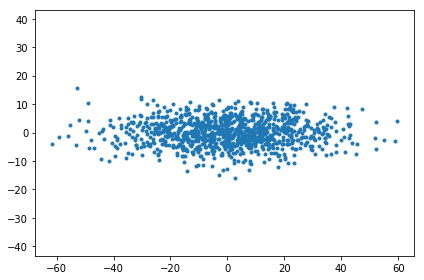

In [7]:
plt.plot(*pc_scores_from_X, '.')
plt.axis('equal')
maybe_save_plot('2018-05-20-pc-scores-from-x')
plt.show()

## Distance matrix

The distance matrix in this case is an $N \times N$ matrix where the element at $i, j$ is the Euclidean distance $\delta_{ij}$ between example $i$ and $j$, and $\delta_{ij} = ||x_i^2 - x_j^2||^2$.

I'll use `sklearn` for this. This gets approximately the same results as

```python
dist = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        diff = X[:, i] - X[:, j]
        dist_squared = diff.T @ diff
        dist[i, j] = dist_squared
```

In [8]:
distance_matrix = euclidean_distances(X.T)**2

For fun, I can plot a corner of the distance matrix. This shows what I'd expect: the diagonal elements are 0 because the distance between a point and itself is 0. It's otherwise symmetric and positive.

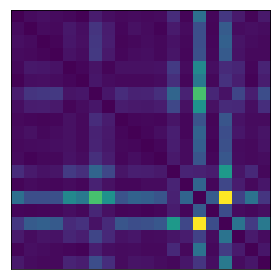

In [9]:
fig, ax = plt.subplots()

ax.imshow(distance_matrix[:20, :20])
hide_ticks(ax)
maybe_save_plot('2018-05-20-distances')
plt.show()

The distances also don't care about whether the original data is centered or not. This makes sense since it's just the points relative to each other, not in relation to a coordinate system.

In [10]:
distance_matrix_from_centered = euclidean_distances(centered_X.T)**2
assert np.allclose(distance_matrix, distance_matrix_from_centered)

## Gram matrix

This way of doing MDS works by getting the Gram matrix from the distance matrix. The Gram matrix is an $N \times N$ matrix given by $X^{\top}X$ using the centered $X$.

In [11]:
actual_gram = centered_X.T @ centered_X

### Double centering the Gram matrix

One can convert a Gram matrix from uncentered data to the Gram matrix from centered data using **double centering**. This makes sense looking at the linear algebra.

$$C_n^{\top} (X^{\top} X) C_n = (X C_n)^{\top} (X C_n)$$

In [12]:
uncentered_gram = X.T @ X

centered_gram = centering_matrix(N).T @ uncentered_gram @ centering_matrix(N)

assert np.allclose(actual_gram, centered_gram)

## PCA from the Gram matrix

It turns out once we have the Gram matrix, there's a way to compute the principal component scores from the Gram matrix.

You can see how this works by looking at the singular value decomposition.
When doing SVD on the observations $X$ directly, then $X$ becomes $X = USV^{\top}$ and the PC scores are given by $SV^\top$. 

Here's what happens to $SV^{\top}$ in the Gram matrix.
Remember S is a diagonal, and $U$ and $V$ are orthonormal (so $U^{\top} = U^{-1}$ and $UU^{\top} = \mathbb{I}$):

\begin{align}
X^{\top}X &= G \\
 &= (USV^{\top})^{\top}(USV^{\top}) \\
 &= VSU^{\top}USV^{\top} \\
 &= VS^2V^{\top}.
\end{align}


Regular [eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) on the Gram matrix gives

$$G = Q\Lambda Q^{\top}.$$

Matching this up with $VS^2V^{\top}$ gives PC scores as $\sqrt{\Lambda} Q^{\top}$ using the top $K$ eigenvalues and eigenvectors.

In [13]:
w, v = np.linalg.eig(centered_gram)
pc_score_from_gram_matrix = np.diag(np.sqrt(w[:K])) @ v.T[:K]

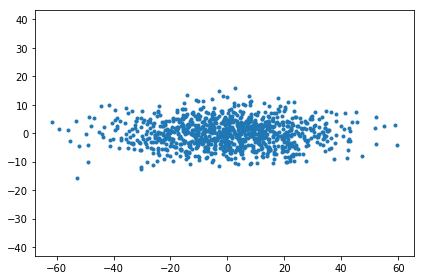

In [14]:
plt.plot(*np.real(pc_score_from_gram_matrix), '.')
plt.axis('equal')
maybe_save_plot('2018-05-20-from-gram')
plt.show()

## Gram matrix from distance matrix.

There's one step missing: computing the Gram matrix from the distance matrix.

It turns out there's a clever way to get the centered Gram matrix out of the distances using the centering matrix again. It's given by

$$G = -\frac{1}{2} C_n \Delta C_n.$$

I can compare the Gram matrix given by this to the actual Gram matrix.

In [15]:
gram_from_dist = -(centering_matrix(N) @ distance_matrix @ centering_matrix(N))/2

assert np.allclose(gram_from_dist, centered_gram)

## MDS

Now I can put it all together!

In [16]:
def MDS(distance_matrix, K):
    # Double checking that the matrix is the right size
    N = distance_matrix.shape[0]
    assert distance_matrix.shape[0] == distance_matrix.shape[1], 'dist should be a square matrix, but it\'s {}x{}'.format(dist.shape)
    
    # Compute the Gram matrix from the distance_matrix
    gram_from_dist = -(centering_matrix(N) @ distance_matrix @ centering_matrix(N))/2

    # Compute the PC scores from Gram matrix
    w, v = np.linalg.eig(gram_from_dist)
    # Double check the eigenvalues are positive. While they will be for 
    # actual distance matrices, this becomes a problem if we extend this
    # to other types of symmetric matrices that may not be positive semi-definite.
    assert np.all(w[:K] > 0)
    proj = np.diag(np.sqrt(w[:K])) @ v.T[:K]
    
    return proj

pc_scores_from_distance_matrix = MDS(distance_matrix, K)

## Viewing them all

When I plot these, I expect the points to be in the same place, though they might be rotated.

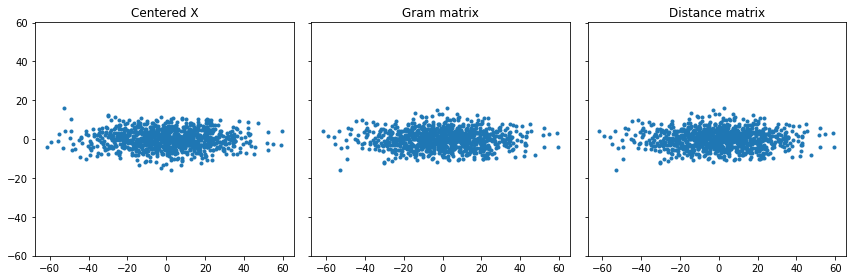

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

axs[0].plot(*pc_scores_from_X, '.')
axs[0].set_title("Centered X")
axs[0].axis('equal')

axs[1].plot(*np.real(pc_score_from_gram_matrix), '.')
axs[1].set_title("Gram matrix")

axs[2].plot(*np.real(pc_scores_from_distance_matrix), '.')
axs[2].set_title("Distance matrix")

maybe_save_plot('2018-05-20-comparison')
plt.show()

## North American Cities example

Inspired by [this video](https://www.youtube.com/watch?v=qZ_QHXJ29iw) let's try MDS using the distances between cities. 

[This website](https://people.sc.fsu.edu/~jburkardt/datasets/cities/cities.html) has data in this form. (Heads up, it's licensed under [GNU LGPL](https://people.sc.fsu.edu/~jburkardt/txt/gnu_lgpl.txt))
I'll use one of the datasets that measure distances using latitude/longitude, rather than road distance. USCA312 is a dataset of 312 cities in the US and Canada.

I'll first download the data and process it.

In [18]:
dataset_name = "usca312"

import requests

def get_data_from_fsu(url):
    response = requests.get(url)
    response_lines = response.text.split('\n')
    for i, line in enumerate(response_lines):
        if not line.startswith('#'):
            break
    return response_lines[i:]

url = "https://people.sc.fsu.edu/~jburkardt/datasets/cities/"

raw_city_labels_data = get_data_from_fsu("{}{}_name.txt".format(url, dataset_name))
raw_city_dists_data = get_data_from_fsu("{}{}_dist.txt".format(url, dataset_name))

In [19]:
# the last element is a blank character
assert raw_city_labels_data[-1] == ''
city_labels = raw_city_labels_data[:-1]

# The txt file splits long rows up, and it's a tiny bit easier to
# just make a big long list and reshape it
raw_city_dists_list = sum([
    list(map(int, line.split()))
    for line in raw_city_dists_data
], [])

city_dist_matrix = np.array(raw_city_dists_list).reshape(
    len(city_labels), 
    len(city_labels)
)

### Computing PC Scores

Now that I have the distance matrix loaded, I'll run the `MDS` function defined above!

In [20]:
locations = MDS(city_dist_matrix, K)

Now I'll plot and label the states/provinces. I strip the city names out of the labels to make it a little easier to read.

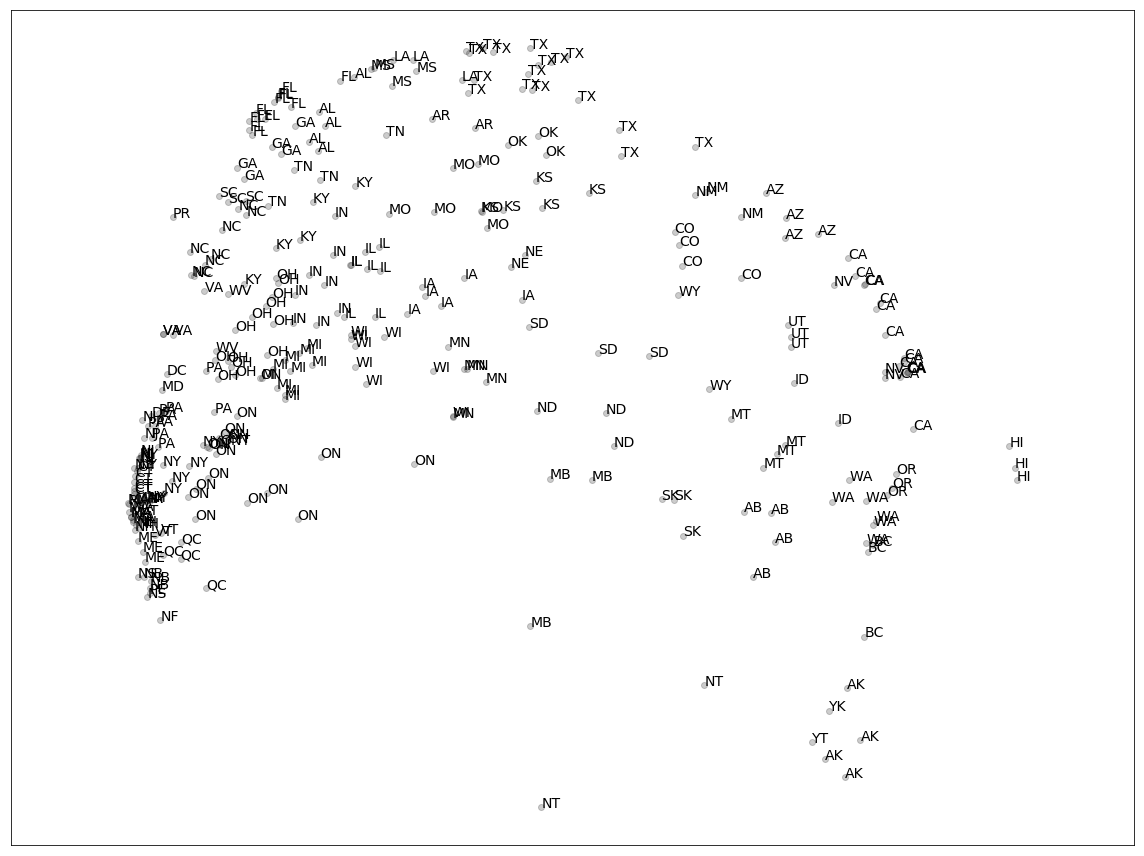

In [21]:
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

plt.plot(locations[0], locations[1], 'ok', alpha=.2)

for label, xy in zip(city_labels, locations.T):
    plt.annotate(label.split(',')[1].strip(), xy, fontsize=14)

hide_ticks(ax)
plt.axis('equal')
    
maybe_save_plot('2018-05-20-north-america')
plt.show()

One more plotting alternative is to plot one label per state/province.

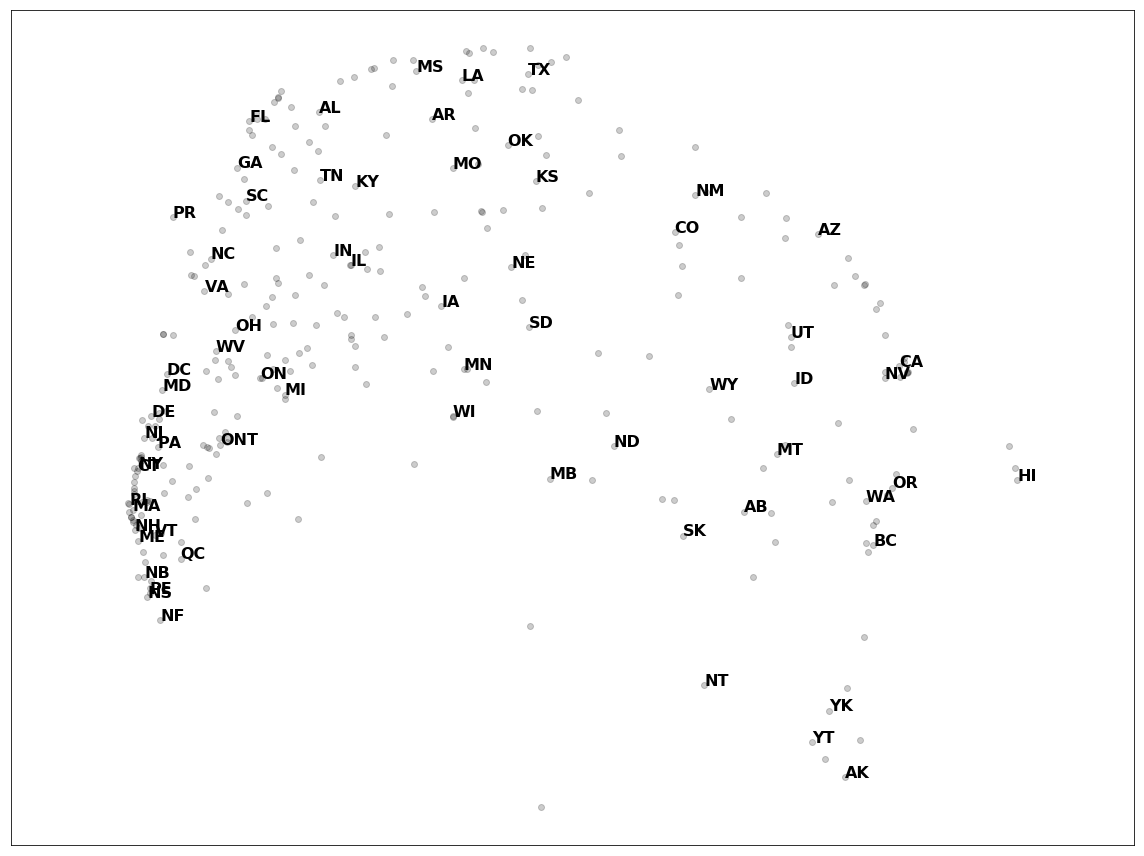

In [22]:
state_or_province_labels = {}
for i, label in enumerate(city_labels):
    state_or_province = label.split(',')[1].strip()
    # it's fine if we overwrite states
    state_or_province_labels[state_or_province] = i

plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

plt.plot(locations[0], locations[1], 'ok', alpha=.2)

annotation_subset = list(state_or_province_labels.values())
for label, idx in state_or_province_labels.items():
    plt.annotate(label, locations[:, idx], fontsize=16, weight='bold')

hide_ticks(ax)
plt.axis('equal')
    
maybe_save_plot('2018-05-20-north-america-per-state-province')
plt.show()

## See Also

 - MDS reminds me of [t-sne](https://distill.pub/2016/misread-tsne/), though MDS works on distance matrices.
 - [DME](http://www.inf.ed.ac.uk/teaching/courses/dme/) is the the course that taught me this.
 - [MDS on Wikipedia](https://en.wikipedia.org/wiki/Multidimensional_scaling).